In [21]:
import os
import time
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import tensorflow as tf

In [22]:
TRAINDIR = "/datasets/home/76/576/hhl045/data/Pneumonia/chest_xray/train"
TESTDIR = "/datasets/home/76/576/hhl045/data/Pneumonia/chest_xray/test"
VALDIR = "/datasets/home/76/576/hhl045/data/Pneumonia/chest_xray/val"


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [24]:
#takes best validation loss
#adapted from: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 9001

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        print('check')
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
#transforms to augment the images so that the model can
#train on more varied presentations of the data
input_size = (224,224)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ColorJitter(brightness=(0.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ColorJitter(brightness=(0.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [26]:
train_folder = datasets.ImageFolder(TRAINDIR,data_transforms['train'])
val_folder = datasets.ImageFolder(VALDIR,data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_folder, batch_size=32,
                                           shuffle=True, num_workers=4, pin_memory=True)
                                                                                

val_loader = torch.utils.data.DataLoader(val_folder, batch_size=32,
                                           shuffle=True, num_workers=4, pin_memory=True)

In [27]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


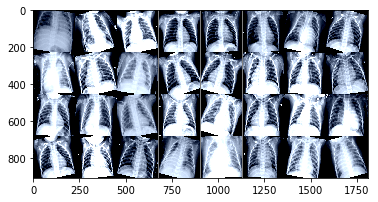

Pneumonia Pneumonia Normal Normal


In [13]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Get some random training images.
classes = ('Normal', 'Pneumonia')
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Training
## SGD Optimzer
### ResNet101

In [ ]:
#Set last layer to two classes
model_ft_resnet101 = models.resnet101(pretrained=True)
num_ft_resnet101 = model_ft_resnet101.fc.in_features
model_ft_resnet101.fc = nn.Linear(num_ft_resnet101, 2)

#Send model to GPU; make optimizer
model_ft_resnet101 = model_ft_resnet101.to(device)
params_to_update = model_ft_resnet101.parameters()
optimizer = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

In [12]:
criterion = nn.CrossEntropyLoss()
num_epochs = 21
# Train and evaluate
model_ft_resnet101.cuda()
model_ft = train_model(model_ft_resnet101, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/20
----------
train Loss: 0.3964 Acc: 0.8614
val Loss: 0.5776 Acc: 0.6875

Epoch 1/20
----------
train Loss: 0.1805 Acc: 0.9426
val Loss: 0.4991 Acc: 0.6875

Epoch 2/20
----------
train Loss: 0.1347 Acc: 0.9534
val Loss: 0.3187 Acc: 0.8750

Epoch 3/20
----------
train Loss: 0.1142 Acc: 0.9590
val Loss: 0.2515 Acc: 0.8750

Epoch 4/20
----------
train Loss: 0.0993 Acc: 0.9636
val Loss: 0.2584 Acc: 0.8750

Epoch 5/20
----------
train Loss: 0.0875 Acc: 0.9700
val Loss: 0.1862 Acc: 0.9375

Epoch 6/20
----------
train Loss: 0.0781 Acc: 0.9747
val Loss: 0.2337 Acc: 0.8750

Epoch 7/20
----------
train Loss: 0.0702 Acc: 0.9765
val Loss: 0.1932 Acc: 0.9375

Epoch 8/20
----------
train Loss: 0.0647 Acc: 0.9789
val Loss: 0.3406 Acc: 0.8750

Epoch 9/20
----------
train Loss: 0.0649 Acc: 0.9785
val Loss: 0.1178 Acc: 0.9375

Epoch 10/20
----------
train Loss: 0.0567 Acc: 0.9812
val Loss: 0.2957 Acc: 0.8125

Epoch 11/20
----------
train Loss: 0.0526 Acc: 0.9838
val Loss: 0.0947 Acc: 1.0000

Ep

In [14]:
torch.save(model_ft_resnet101.state_dict(),'/datasets/home/76/576/hhl045/Pneumonia/resnet101_finetuned.pt')

### Densenet161

In [8]:
#Load pretrained model; Set last layer to two classes
model_ft_dnet161 = models.densenet161(pretrained=True)
num_ftrs = model_ft_dnet161.classifier.in_features
model_ft_dnet161.classifier = nn.Linear(num_ftrs, 2)

#Send model to GPU; make optimizer
model_ft_dnet161 = model_ft_dnet161.to(device)
optimizer = optim.SGD(model_ft_dnet161.parameters(), lr=0.0001, momentum=0.9)

/opt/conda/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [9]:
criterion = nn.CrossEntropyLoss()
num_epochs = 21
# Train and evaluate
model_ft_dnet161.cuda()
model_ft = train_model(model_ft_dnet161, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/20
----------
train Loss: 0.3409 Acc: 0.9009
val Loss: 0.3012 Acc: 0.8750

Epoch 1/20
----------
train Loss: 0.1610 Acc: 0.9448
val Loss: 0.2741 Acc: 0.8125

Epoch 2/20
----------
train Loss: 0.1181 Acc: 0.9586
val Loss: 0.1453 Acc: 1.0000

Epoch 3/20
----------
train Loss: 0.0961 Acc: 0.9693
val Loss: 0.1074 Acc: 1.0000

Epoch 4/20
----------
train Loss: 0.0876 Acc: 0.9695
val Loss: 0.2215 Acc: 0.9375

Epoch 5/20
----------
train Loss: 0.0794 Acc: 0.9717
val Loss: 0.0704 Acc: 1.0000

Epoch 6/20
----------
train Loss: 0.0726 Acc: 0.9758
val Loss: 0.3081 Acc: 0.8750

Epoch 7/20
----------
train Loss: 0.0639 Acc: 0.9778
val Loss: 0.1637 Acc: 1.0000

Epoch 8/20
----------
train Loss: 0.0621 Acc: 0.9795
val Loss: 0.1505 Acc: 0.9375

Epoch 9/20
----------
train Loss: 0.0580 Acc: 0.9789
val Loss: 0.0938 Acc: 0.9375

Epoch 10/20
----------
train Loss: 0.0562 Acc: 0.9811
val Loss: 0.0444 Acc: 1.0000

Epoch 11/20
----------
train Loss: 0.0534 Acc: 0.9811
val Loss: 0.0686 Acc: 1.0000

Ep

In [10]:
torch.save(model_ft_dnet161.state_dict(),'/datasets/home/76/576/hhl045/Pneumonia/densenet161_finetuned.pt')

### VGG19

In [11]:
#Load pretrained model; Set last layer to two classes
model_ft_vgg19 = models.vgg19(pretrained=True)
num_ftrs = model_ft_vgg19.classifier[6].in_features
model_ft_vgg19.classifier[6] = nn.Linear(num_ftrs, 2)

#Send model to GPU; make optimizer
model_ft_vgg19 = model_ft_vgg19.to(device)
optimizer = optim.SGD(model_ft_vgg19.parameters(), lr=0.0001, momentum=0.9)

In [12]:
criterion = nn.CrossEntropyLoss()
num_epochs = 21
# Train and evaluate
model_ft_vgg19.cuda()
model_ft = train_model(model_ft_vgg19, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/20
----------
train Loss: 0.2798 Acc: 0.8742
val Loss: 0.1631 Acc: 0.9375

Epoch 1/20
----------
train Loss: 0.1227 Acc: 0.9519
val Loss: 0.1093 Acc: 1.0000

Epoch 2/20
----------
train Loss: 0.1034 Acc: 0.9627
val Loss: 0.1479 Acc: 0.9375

Epoch 3/20
----------
train Loss: 0.0832 Acc: 0.9715
val Loss: 0.2154 Acc: 0.8750

Epoch 4/20
----------
train Loss: 0.0743 Acc: 0.9739
val Loss: 0.2165 Acc: 0.8750

Epoch 5/20
----------
train Loss: 0.0707 Acc: 0.9737
val Loss: 0.3633 Acc: 0.8750

Epoch 6/20
----------
train Loss: 0.0603 Acc: 0.9777
val Loss: 0.1756 Acc: 0.8750

Epoch 7/20
----------
train Loss: 0.0602 Acc: 0.9789
val Loss: 0.1854 Acc: 0.8750

Epoch 8/20
----------
train Loss: 0.0552 Acc: 0.9796
val Loss: 0.1597 Acc: 0.9375

Epoch 9/20
----------
train Loss: 0.0540 Acc: 0.9808
val Loss: 0.1265 Acc: 0.9375

Epoch 10/20
----------
train Loss: 0.0441 Acc: 0.9834
val Loss: 0.0960 Acc: 0.9375

Epoch 11/20
----------
train Loss: 0.0477 Acc: 0.9837
val Loss: 0.1483 Acc: 0.9375

Ep

In [14]:
torch.save(model_ft_vgg19.state_dict(),'/datasets/home/76/576/hhl045/Pneumonia/vgg19_finetuned.pt')

## Adam optimizer

In [30]:
criterion = nn.CrossEntropyLoss()
num_epochs = 21

### ResNet101

In [9]:
#Set last layer to two classes
adam_resnet101 = models.resnet101(pretrained=True)
num_ft_resnet101 = adam_resnet101.fc.in_features
adam_resnet101.fc = nn.Linear(num_ft_resnet101, 2)

#Send model to GPU; make optimizer
adam_resnet101 = adam_resnet101.to(device)
params_to_update = adam_resnet101.parameters()
optimizer = optim.Adam(adam_resnet101.parameters(),lr=0.0001, weight_decay=.00001)

In [11]:
adam_resnet101.cuda()
adam_resnet101 = train_model(adam_resnet101, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/20
----------
train Loss: 0.1128 Acc: 0.9570
val Loss: 0.2896 Acc: 0.8750

Epoch 1/20
----------
train Loss: 0.0632 Acc: 0.9758
val Loss: 0.0411 Acc: 1.0000

Epoch 2/20
----------
train Loss: 0.0465 Acc: 0.9843
val Loss: 0.1264 Acc: 0.9375

Epoch 3/20
----------
train Loss: 0.0352 Acc: 0.9866
val Loss: 0.0924 Acc: 0.9375

Epoch 4/20
----------
train Loss: 0.0322 Acc: 0.9890
val Loss: 0.6508 Acc: 0.8750

Epoch 5/20
----------
train Loss: 0.0324 Acc: 0.9892
val Loss: 0.1810 Acc: 0.9375

Epoch 6/20
----------
train Loss: 0.0212 Acc: 0.9933
val Loss: 0.0736 Acc: 1.0000

Epoch 7/20
----------
train Loss: 0.0263 Acc: 0.9905
val Loss: 0.2108 Acc: 0.8750

Epoch 8/20
----------
train Loss: 0.0127 Acc: 0.9964
val Loss: 0.0256 Acc: 1.0000

Epoch 9/20
----------
train Loss: 0.0265 Acc: 0.9904
val Loss: 0.0049 Acc: 1.0000

Epoch 10/20
----------
train Loss: 0.0169 Acc: 0.9952
val Loss: 0.3705 Acc: 0.8750

Epoch 11/20
----------
train Loss: 0.0214 Acc: 0.9925
val Loss: 0.4599 Acc: 0.8750

Ep

In [12]:
torch.save(adam_resnet101.state_dict(),'/datasets/home/76/576/hhl045/Pneumonia/adam_resnet101.pt')

### DenseNet161

In [13]:
#Load pretrained model; Set last layer to two classes
adam_dnet161 = models.densenet161(pretrained=True)
num_ftrs = adam_dnet161.classifier.in_features
adam_dnet161.classifier = nn.Linear(num_ftrs, 2)

#Send model to GPU; make optimizer
adam_dnet161 = adam_dnet161.to(device)
optimizer = optim.Adam(adam_dnet161.parameters(),lr=0.0001, weight_decay=.00001)

/opt/conda/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
adam_dnet161.cuda()
adam_dnet161 = train_model(adam_dnet161, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/20
----------
train Loss: 0.1018 Acc: 0.9619
val Loss: 0.0555 Acc: 1.0000

Epoch 1/20
----------
train Loss: 0.0472 Acc: 0.9850
val Loss: 0.1861 Acc: 0.8750

Epoch 2/20
----------
train Loss: 0.0346 Acc: 0.9886
val Loss: 0.4045 Acc: 0.8750

Epoch 3/20
----------
train Loss: 0.0294 Acc: 0.9890
val Loss: 0.2774 Acc: 0.9375

Epoch 4/20
----------
train Loss: 0.0249 Acc: 0.9914
val Loss: 0.3100 Acc: 0.9375

Epoch 5/20
----------
train Loss: 0.0202 Acc: 0.9934
val Loss: 0.3694 Acc: 0.9375

Epoch 6/20
----------
train Loss: 0.0116 Acc: 0.9957
val Loss: 0.1799 Acc: 0.9375

Epoch 7/20
----------
train Loss: 0.0124 Acc: 0.9953
val Loss: 0.9105 Acc: 0.8125

Epoch 8/20
----------
train Loss: 0.0141 Acc: 0.9960
val Loss: 0.1590 Acc: 0.9375

Epoch 9/20
----------
train Loss: 0.0165 Acc: 0.9942
val Loss: 0.0798 Acc: 1.0000

Epoch 10/20
----------
train Loss: 0.0107 Acc: 0.9968
val Loss: 0.2218 Acc: 0.9375

Epoch 11/20
----------
train Loss: 0.0049 Acc: 0.9990
val Loss: 0.6770 Acc: 0.8125

Ep

In [ ]:
torch.save(adam_dnet161.state_dict(),'/datasets/home/76/576/hhl045/Pneumonia/adam_dnet161.pt')

### VGG19

In [28]:
#Load pretrained model; Set last layer to two classes
adam_vgg19 = models.vgg19(pretrained=True)
num_ftrs = adam_vgg19.classifier[6].in_features
adam_vgg19.classifier[6] = nn.Linear(num_ftrs, 2)

#Send model to GPU; make optimizer
adam_vgg19 = adam_vgg19.to(device)
optimizer = optim.Adam(adam_vgg19.parameters(),lr=0.0001, weight_decay=.00001)

In [31]:
adam_vgg19.cuda()
adam_vgg19 = train_model(adam_vgg19, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/20
----------
train Loss: 0.1962 Acc: 0.9213
val Loss: 0.1550 Acc: 0.9375

Epoch 1/20
----------
train Loss: 0.0858 Acc: 0.9710
val Loss: 0.0720 Acc: 1.0000

Epoch 2/20
----------
train Loss: 0.0658 Acc: 0.9768
val Loss: 0.0247 Acc: 1.0000

Epoch 3/20
----------
train Loss: 0.0571 Acc: 0.9809
val Loss: 0.3206 Acc: 0.8750

Epoch 4/20
----------
train Loss: 0.0675 Acc: 0.9755
val Loss: 0.1570 Acc: 0.9375

Epoch 5/20
----------
train Loss: 0.0477 Acc: 0.9841
val Loss: 0.1517 Acc: 0.8750

Epoch 6/20
----------
train Loss: 0.0383 Acc: 0.9870
val Loss: 0.0439 Acc: 1.0000

Epoch 7/20
----------
train Loss: 0.0395 Acc: 0.9865
val Loss: 0.1778 Acc: 0.8750

Epoch 8/20
----------
train Loss: 0.0317 Acc: 0.9891
val Loss: 0.0358 Acc: 1.0000

Epoch 9/20
----------
train Loss: 0.0283 Acc: 0.9898
val Loss: 0.8346 Acc: 0.8125

Epoch 10/20
----------
train Loss: 0.0359 Acc: 0.9878
val Loss: 0.1607 Acc: 0.9375

Epoch 11/20
----------
train Loss: 0.0311 Acc: 0.9899
val Loss: 0.0964 Acc: 0.9375

Ep

In [32]:
torch.save(adam_vgg19.state_dict(),'/datasets/home/76/576/hhl045/Pneumonia/adam_vgg19.pt')

# Testing

In [3]:
import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch import nn
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [4]:
sess = tf.InteractiveSession()

In [11]:
def evaluate(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    predictions = []
    ground_truths = []
    label_list = []
    pred_list = []
    
    with torch.set_grad_enabled(False):
        for imgs, labels in test_dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs=model(imgs)
            _, preds = torch.max(outputs, 1)
            predictions.append(preds)
            ground_truths.append(labels)
    
    for batch in ground_truths:
        for j in (batch.cpu().numpy()):
            label_list.append(j)

    for batch in predictions:
        for j in (batch.cpu().numpy()):
            pred_list.append(j)
    
    return label_list,pred_list

def precision_recall(cm):
    tn, fp, fn, tp = cm.ravel()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)

    print("Recall of the model is {:.2f}".format(recall))
    print("Precision of the model is {:.2f}".format(precision))

In [6]:
TESTDIR = "/datasets/home/76/576/hhl045/data/Pneumonia/chest_xray/test"

test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = datasets.ImageFolder(TESTDIR,test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 32, num_workers = 4)

## SGD Optimized Models
### ResNet101

In [19]:
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('/datasets/home/76/576/hhl045/Pneumonia/resnet101_finetuned.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [25]:
labels, preds = evaluate(model,test_dataloader)

<Figure size 432x288 with 0 Axes>

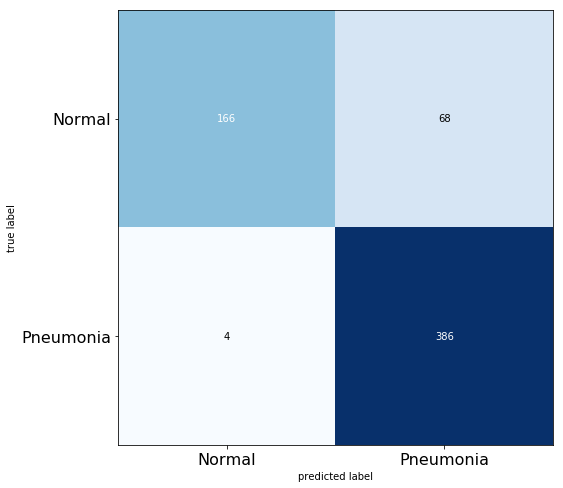

In [26]:
cm = confusion_matrix(labels,preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [27]:
precision_recall(cm)

Recall of the model is 0.99
Precision of the model is 0.85


### DenseNet161

In [28]:
labels, preds = evaluate(model_ft_dnet161,test_dataloader)

<Figure size 432x288 with 0 Axes>

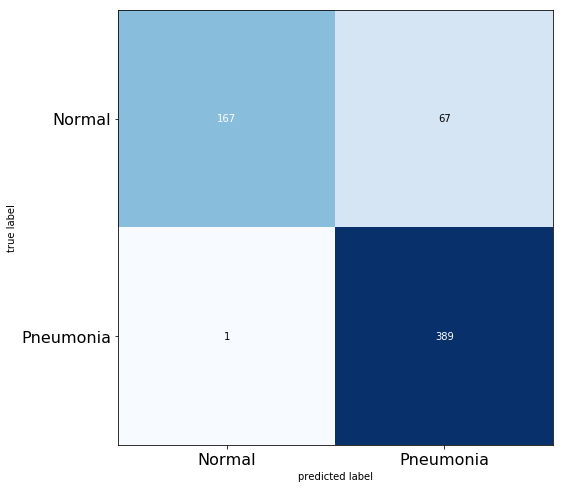

In [29]:
cm = confusion_matrix(labels,preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [30]:
precision_recall(cm)

Recall of the model is 1.00
Precision of the model is 0.85


### VGG19

In [31]:
labels, preds = evaluate(model_ft_vgg19,test_dataloader)

<Figure size 432x288 with 0 Axes>

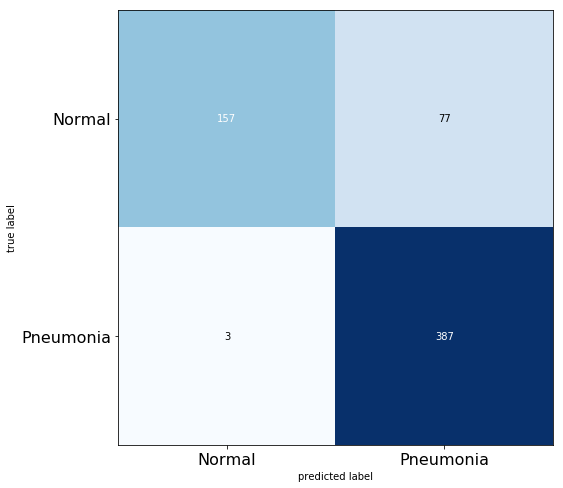

In [32]:
cm = confusion_matrix(labels,preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [33]:
precision_recall(cm)

Recall of the model is 0.99
Precision of the model is 0.83


## Adam Optimized Models
### ResNet101

In [7]:
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('/datasets/home/76/576/hhl045/Pneumonia/adam_resnet101.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [8]:
labels, preds = evaluate(model,test_dataloader)

<Figure size 432x288 with 0 Axes>

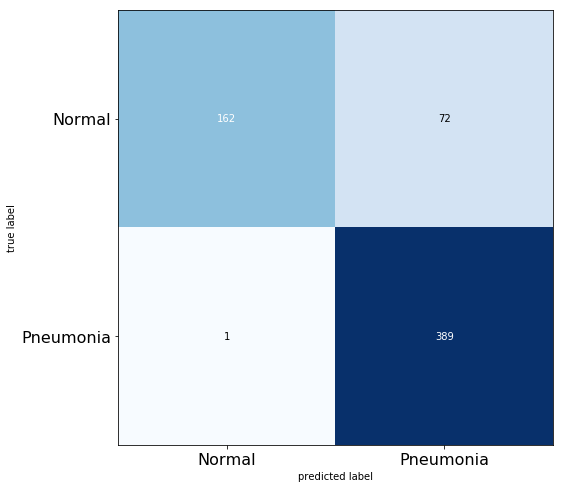

In [9]:
cm = confusion_matrix(labels,preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [12]:
precision_recall(cm)

Recall of the model is 1.00
Precision of the model is 0.84


### DenseNet161

In [16]:
model = models.densenet161(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('/datasets/home/76/576/hhl045/Pneumonia/adam_dnet161.pt'))
model.eval()

/opt/conda/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [18]:
labels, preds = evaluate(model, test_dataloader)

<Figure size 432x288 with 0 Axes>

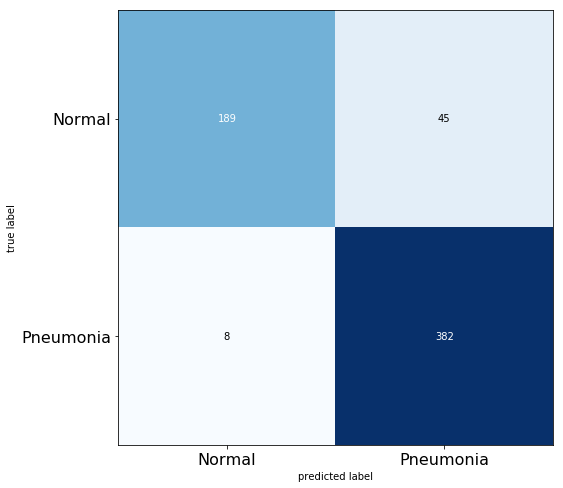

In [19]:
cm = confusion_matrix(labels,preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [20]:
precision_recall(cm)

Recall of the model is 0.98
Precision of the model is 0.89


In [35]:
labels, preds = evaluate(model, test_dataloader)

<Figure size 432x288 with 0 Axes>

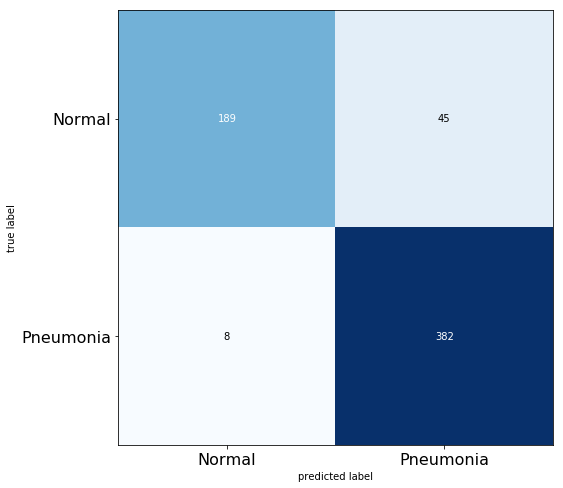

In [36]:
cm = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [37]:
precision_recall(cm)

Recall of the model is 0.98
Precision of the model is 0.89
